In [49]:
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *

BATCH_SIZE=128
IMAGE_SIZE=(64,64)
train_loader,val_loader=create_dataloader(IMAGE_SIZE,batch_size=BATCH_SIZE)



In [50]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten the tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

In [51]:
import torch
import train 
importlib.reload(train)
from train import training_loop

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)


# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
loss_fn= DiceLoss()
unet_metrics=training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=3)
# Train the model


Using cache found in /Users/anton_heden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Starting training
Training on device mps


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Epoch 1/3: Train loss: 0.832, Train f1.: 0.169, Train accuracy: 0.895, Val. loss: 0.693, Val. f1.: 0.308 Val. accuracy: 0.860


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Epoch 2/3: Train loss: 0.552, Train f1.: 0.449, Train accuracy: 0.926, Val. loss: 0.568, Val. f1.: 0.433 Val. accuracy: 0.901


100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Epoch 3/3: Train loss: 0.439, Train f1.: 0.562, Train accuracy: 0.954, Val. loss: 0.446, Val. f1.: 0.556 Val. accuracy: 0.947


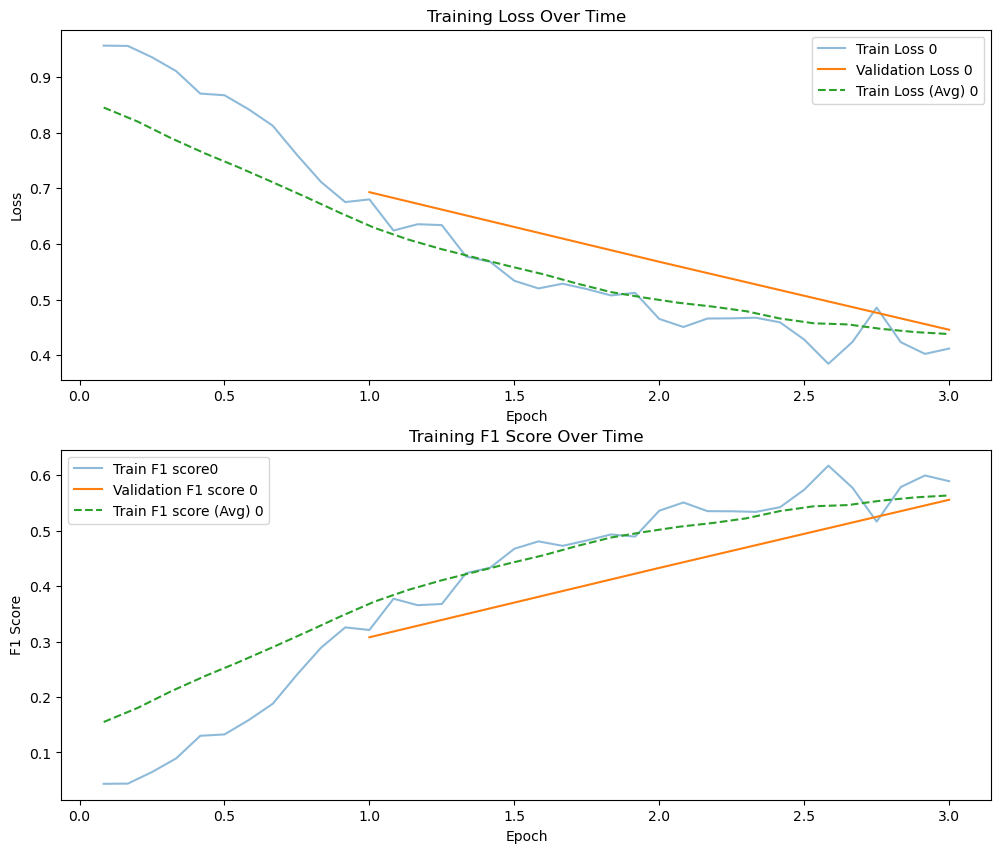

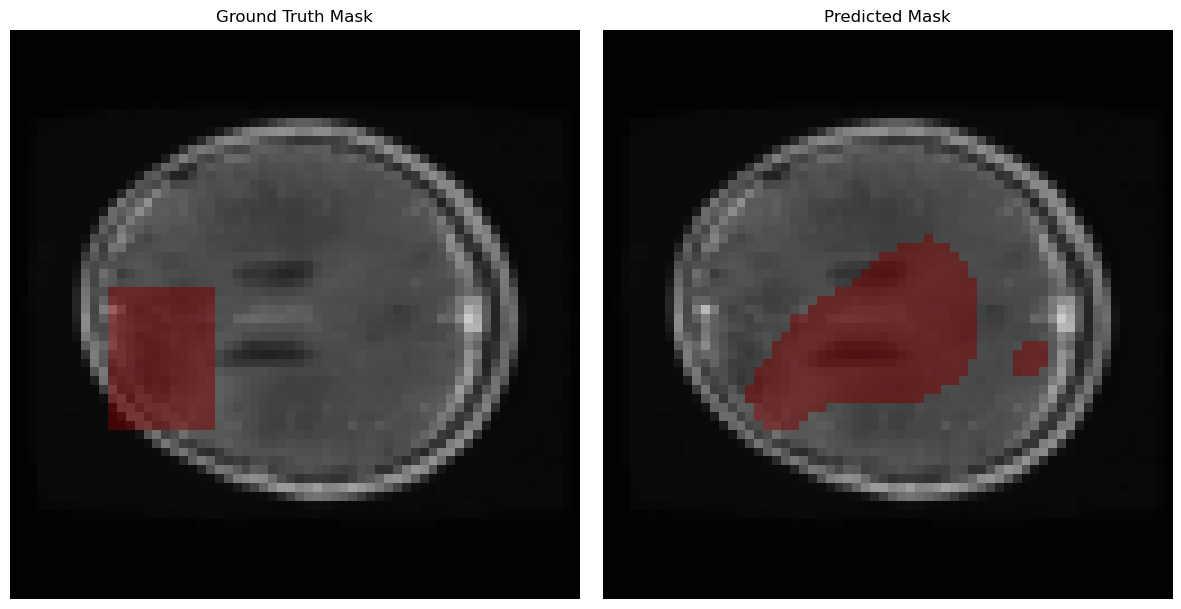

In [52]:
import visualisation
importlib.reload(visualisation)
from visualisation import *
#save_model_to_file(unet_metrics, 'unet_brain2_seg.pth')


plot_performance_metrics([unet_metrics],batch_size=BATCH_SIZE)
val_dataset = val_loader.dataset


# Plot comparison for a specific index
plot_comparison([0], val_dataset, unet_metrics[0])

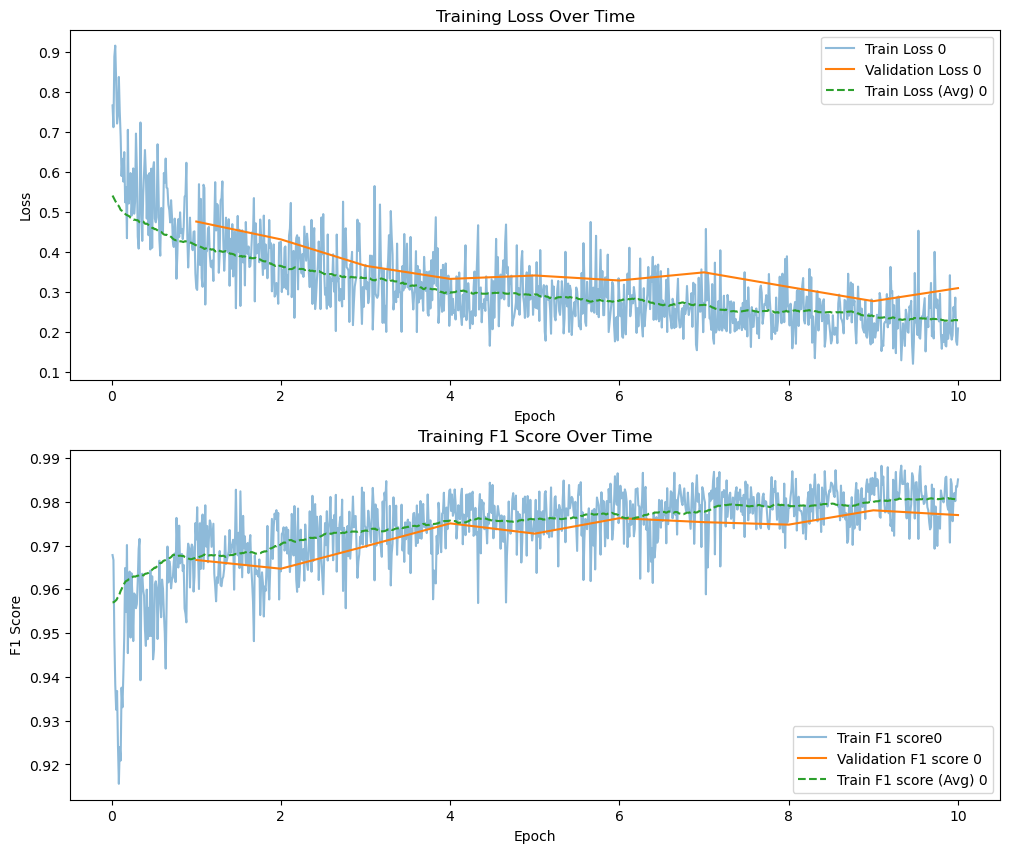

(64, 64)
(64, 64)


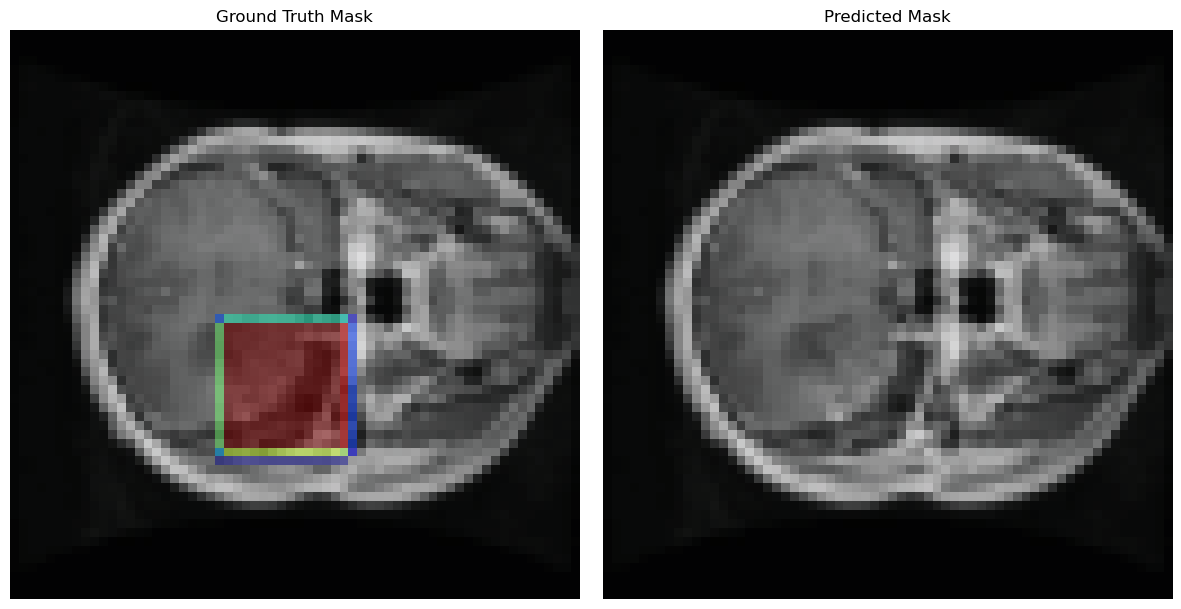

In [33]:
import visualisation
importlib.reload(visualisation)
from visualisation import *
# Load the model and performance metrics
trained_metrics = get_model_and_performance_metrics("unet_brain_seg.pth", model)
plot_performance_metrics([trained_metrics],batch_size=16)

# Get the validation dataset
val_dataset = val_loader.dataset


# Plot comparison for a specific index
plot_comparison([1], val_dataset, model)